In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dados1 = pd.read_excel("dataset_dengue.xlsx") # Lendos os dados.

#Inserir uma coluna "meses" para usar como referência de data, com os mesmos valores que o index
meses = []
for i in dados1.index:
    meses.append(i)

dados1.insert(6, "meses", meses, True)

In [3]:
x= dados1["meses"]
y=dados1["casos-confirmados"]

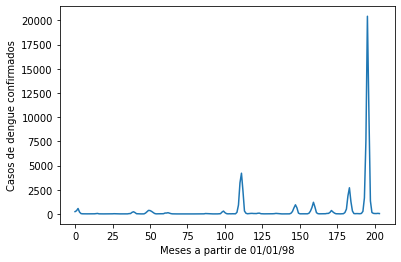

In [4]:
#Plotando os casos em função dos meses para relembrar o problema a ser estudado

plt.plot(x,y)

plt.xlabel("Meses a partir de 01/01/98")
plt.ylabel("Casos de dengue confirmados")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

# Definir datasets de treino e teste, e hiperparâmetros gerais para todos os testes.  
# Estratégia Holdout

TAMANHO_TESTE = 0.15 # quantidade de dados usados para o teste (15%)
SEMENTE_ALEATORIA = 1496
FEATURES = ["chuva", "temperatura-media", "temperatura-mininima", "temperatura-maxima", "meses"]
TARGET = ["casos-confirmados"]

df = dados1

indices = df.index
indices_treino, indices_teste = train_test_split( 
    #função de sorteio pseudo-aleatório para separação de identificadores únicos no DataFrame.
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
    #esta função faz com que a separação dos dados seja aleatória, mas sempre seja a mesma.
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values
X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

# Normalizador 

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)



MinMaxScaler()

# Árvore de decisão

A árvore de decisão foi escolhida devido ao seu desempenho ao estudarmos os modelos para aprendizado supervisionado.

In [6]:
# cria, treina o modelo e realiza a validação cruzada com todos os hiperparâmetros desejados

lista_scores = []
Numero_de_folhas=[2,3,4,5,6,7,8]

for i in Numero_de_folhas:
    modelo = DecisionTreeRegressor(
        max_leaf_nodes=i,
        max_depth=None,
        random_state=SEMENTE_ALEATORIA,
    )
    modelo.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

    y_verdadeiro = normalizador_y.transform(y_teste)
    y_previsao = modelo.predict(normalizador_x.transform(X_teste))

    scores = cross_val_score(
        modelo,
        X_treino,
        y_treino,
        cv=3,
        scoring="neg_root_mean_squared_error",
    )

    lista_scores.append(scores.mean())


ValueError: x and y must have same first dimension, but have shapes (7,) and (6,)

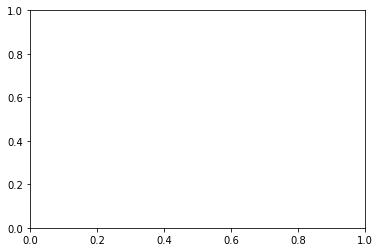

In [11]:
lista=Numero_de_folhas
plt.plot(lista,lista_scores)
plt.title("Score em -RMSE para o modelo Árvore de decisão")
plt.xlabel("Folhas")
plt.ylabel("Casos")
plt.show()

Observa-se que a partir de 4 folhas não há ganho significativo no desempenho do modelo. 

# Modelo k-nearest neighbors

O modelo K-nn também foi escolhido pelos resultados apresentados ao estudarmos os modelos de aprendizado supervisionado.

In [8]:
# cria, treina o modelo e realiza a validação cruzada com todos os hiperparâmetros desejados
VIZINHOS = [3, 4, 6, 8, 10, 12]
lista_scores = []

for n in VIZINHOS:

    modelo = KNeighborsRegressor(n_neighbors=n)

    modelo.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

    y_verdadeiro = normalizador_y.transform(y_teste)
    y_previsao = modelo.predict(normalizador_x.transform(X_teste))

    scores = cross_val_score(
        modelo,
        X_treino,
        y_treino,
        cv=3,
        scoring="neg_root_mean_squared_error",
    )
    
    lista_scores.append(scores.mean())

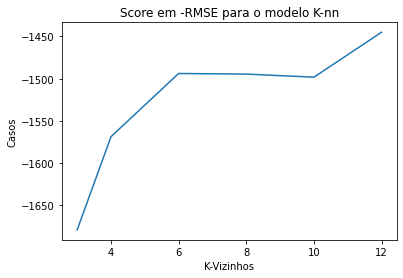

In [10]:
lista=VIZINHOS

plt.plot(lista,lista_scores)
plt.title("Score em -RMSE para o modelo K-nn")
plt.xlabel("K-Vizinhos")
plt.ylabel("Casos")
plt.show()

É interessante ver que o modelo possui um padrão de melhora com "n" sendo valor sazonal, com o melhor desempenho (dentre os hiperparâmetros testados) é com n sendo 12 meses, ou 1 ano. No entanto seu score abaixo em relação ao obtido com a árvore de decisão.

Apesar da árvore de decisão ter tido o menor score com o seu hiperparâmetro razoavelmente bom dentre os modelos testados, esse modelo continua não sendo um bom candidato para realizar predições dos casos de dengue. Os nossos dados não são suficientes para realizar predições do target desejado, portanto, é necessário que se encontre novas features para auxiliar a modelagem.